In [1]:
from datasets import load_from_disk
processed_dataset = load_from_disk("processed_data")

In [2]:
from torch.utils.data import DataLoader
import os
import torch

def collate_fn(batch):
    images = torch.stack([
        torch.stack([
            torch.tensor(row, dtype=torch.float32) for row in item["image"]
        ], dim=1).permute(2, 0, 1)
        for item in batch
    ])

    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    return {"image": images, "label": labels}
base_path = "./data"

train_dataset = torch.load(os.path.join(base_path, "train.pt"))
val_dataset = torch.load(os.path.join(base_path, "val.pt"))
test_dataset = torch.load(os.path.join(base_path, "test.pt"))

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=4,
    pin_memory=True, prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=4,
    pin_memory=True, prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=4,
    pin_memory=True, prefetch_factor=2
)

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from transformers import ViTModel

class ArtClass(nn.Module):
    def __init__(self, num_classes):
        super(ArtClass, self).__init__()
        
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        
        resnet_feature_dim = 2048
        vit_feature_dim = 768
        
        self.fusion = nn.Linear(resnet_feature_dim + vit_feature_dim, 512)
        self.dropout_fusion = nn.Dropout(p=0.5)
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        resnet_features = self.resnet(x)
        
        vit_features = self.vit(pixel_values=x).last_hidden_state[:, 0, :]
        
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        
        fused_features = self.fusion(combined_features)
        fused_features = self.dropout_fusion(fused_features)
        
        out = self.classifier(fused_features)
        return out


In [ ]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_styles = len(set(processed_dataset["label"]))
model = ArtClass(num_classes=num_styles).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

for param in model.resnet.parameters():
    param.requires_grad = True
for param in model.vit.parameters():
    param.requires_grad = True
    
best_val_accuracy = 0.0
best_model_state = None
for epoch in range(10):
    model.train()
    print(f"Epoch {epoch+1}")
    start = time.time()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch in train_loader:
        images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
        labels = batch["label"].clone().detach().to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    
    train_loss /= total
    train_accuracy = 100 * correct / total
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Elapsed time: {(time.time() - start)/60:.2f} minutes")
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
            labels = batch["label"].clone().detach().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)
    
    val_loss /= val_total
    val_accuracy = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Elapsed time: {(time.time() - start)/60:.2f} minutes")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_hybrid.pth")
    torch.cuda.empty_cache()

model.load_state_dict(torch.load("best_hybrid.pth"))

Epoch 1
Training Loss: 2.3868, Accuracy: 26.93%, Elapsed time: 27.53 minutes
Validation Loss: 2.0567, Accuracy: 35.15%, Elapsed time: 28.34 minutes
Epoch 2
Training Loss: 1.9018, Accuracy: 40.12%, Elapsed time: 27.48 minutes
Validation Loss: 1.7655, Accuracy: 43.60%, Elapsed time: 28.27 minutes
Epoch 3
Training Loss: 1.5785, Accuracy: 49.99%, Elapsed time: 27.46 minutes
Validation Loss: 1.7203, Accuracy: 46.20%, Elapsed time: 28.38 minutes
Epoch 4
Training Loss: 1.2986, Accuracy: 58.52%, Elapsed time: 27.48 minutes
Validation Loss: 1.7540, Accuracy: 46.65%, Elapsed time: 28.25 minutes
Epoch 5
Training Loss: 1.0270, Accuracy: 67.51%, Elapsed time: 27.91 minutes
Validation Loss: 1.9233, Accuracy: 47.35%, Elapsed time: 28.70 minutes
Epoch 6
Training Loss: 0.8114, Accuracy: 74.54%, Elapsed time: 27.46 minutes
Validation Loss: 2.0667, Accuracy: 46.35%, Elapsed time: 28.24 minutes
Epoch 7


Uncomment and run the next two cells to generate classification report and confusion matrix if kernel restarts.

In [4]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet50
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_styles = len(set(processed_dataset["label"]))
# model = ArtClass(num_classes=num_styles).to(device)
# for param in model.resnet.parameters():
#     param.requires_grad = True
# for param in model.vit.parameters():
#     param.requires_grad = True

# model = model.to(device)
# model.load_state_dict(torch.load("best_hybrid.pth"))

<All keys matched successfully>

In [8]:
# from torch.utils.data import DataLoader

# def collate_fn(batch):
#     images = torch.stack([
#         torch.stack([
#             torch.tensor(row, dtype=torch.float32) for row in item["image"]
#         ], dim=1).permute(2, 0, 1)
#         for item in batch
#     ])

#     labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

#     return {"image": images, "label": labels}

# test_dataset = torch.load("./data/test.pt")

# test_loader = DataLoader(
#     test_dataset, 
#     batch_size=32, 
#     shuffle=True, 
#     collate_fn=collate_fn, 
#     num_workers=4,
#     pin_memory=True, prefetch_factor=2
# )

Test Accuracy: 46.50%


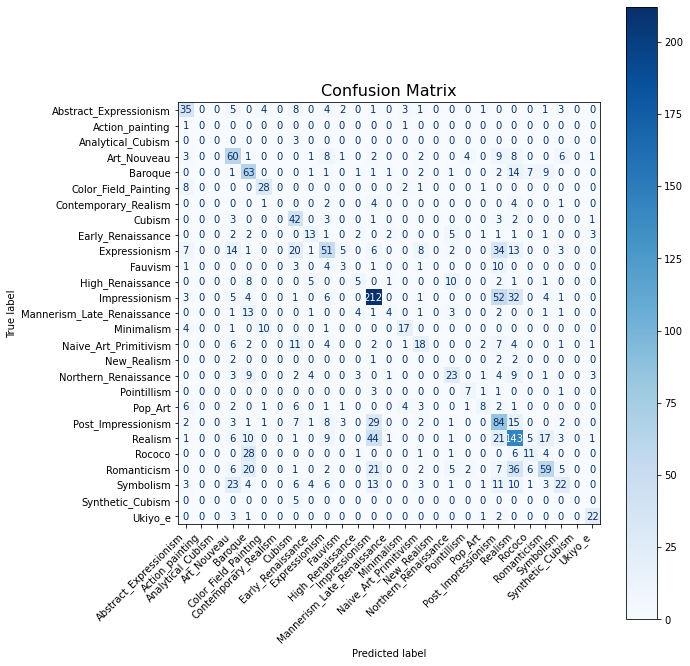

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy
import json

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
        labels = batch["label"].clone().detach().to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

with open("num_to_style.json", "r") as f:
    num_to_style = json.load(f)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[num_to_style[str(i)] for i in range(len(num_to_style))])
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report

class_names = [num_to_style[str(i)] for i in range(len(num_to_style))]

report = classification_report(
    true_labels, 
    predicted_labels, 
    target_names=class_names, 
    digits=4
)
print(report)

                            precision    recall  f1-score   support

    Abstract_Expressionism     0.4730    0.5147    0.4930        68
           Action_painting     0.0000    0.0000    0.0000         2
         Analytical_Cubism     0.0000    0.0000    0.0000         3
               Art_Nouveau     0.4110    0.5660    0.4762       106
                   Baroque     0.3772    0.6058    0.4649       104
      Color_Field_Painting     0.6222    0.7000    0.6588        40
      Contemporary_Realism     0.0000    0.0000    0.0000        12
                    Cubism     0.3621    0.7636    0.4912        55
         Early_Renaissance     0.4194    0.3824    0.4000        34
             Expressionism     0.4595    0.3091    0.3696       165
                   Fauvism     0.2000    0.1304    0.1579        23
          High_Renaissance     0.3125    0.1515    0.2041        33
             Impressionism     0.6199    0.6604    0.6395       321
Mannerism_Late_Renaissance     0.4000    0.1250

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
